In [ ]:
# Ignore InterpolationMode warnings from torchmeta
import warnings

warnings.filterwarnings("ignore")

In [ ]:
pip install torchmeta

In [ ]:
import os

import easydict
import matplotlib.pyplot as plt

# torch <= 1.9.1
import torch
import torch.nn as nn
import torch.nn.functional as F

# In Colab, install torchmeta using 'pip install torchmeta'
from torchmeta.datasets.helpers import omniglot
from torchmeta.utils.data import BatchMetaDataLoader
from tqdm import tqdm

In [ ]:
def get_dataloader(args):
    train_dataset = omniglot(
        args.folder,
        shots=args.num_shots,
        # test_shots=1, # default = shots
        ways=args.num_ways,
        shuffle=True,
        meta_train=True,
        download=args.download,
    )
    train_dataloader = BatchMetaDataLoader(
        train_dataset, batch_size=args.task_batch_size, shuffle=True, num_workers=1
    )

    test_dataset = omniglot(
        args.folder,
        shots=args.num_shots,
        # test_shots=1, # default = shots
        ways=args.num_ways,
        shuffle=True,
        meta_test=True,
        download=args.download,
    )
    test_dataloader = BatchMetaDataLoader(
        test_dataset, batch_size=args.task_batch_size, shuffle=True, num_workers=1
    )

    val_dataset = omniglot(
        args.folder,
        shots=args.num_shots,
        # test_shots=1, # default = shots
        ways=args.num_ways,
        shuffle=True,
        meta_val=True,
        download=args.download,
    )
    val_dataloader = BatchMetaDataLoader(
        val_dataset, batch_size=args.task_batch_size, shuffle=True, num_workers=1
    )

    return train_dataloader, test_dataloader, val_dataloader

In [ ]:
def save_model(args, model, title):
    if not os.path.isdir(args.output_folder):
        os.mkdir(args.output_folder)
    filename = os.path.join(args.output_folder, title)
    with open(filename, "wb") as f:
        state_dict = model.state_dict()
        torch.save(state_dict, f)
    print("model saved in", filename)


def load_model(args, model, title):
    print("Load model")
    filename = os.path.join(args.output_folder, title)
    model.load_state_dict(torch.load(filename))

In [ ]:
def print_graph(train_accuracies, val_accuracies, train_losses, val_losses):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    axs[0].plot(train_accuracies, label="train_acc")
    axs[0].plot(val_accuracies, label="test_acc")
    axs[0].set_title("Accuracy")
    axs[0].legend()

    axs[1].plot(train_losses, label="train_loss")
    axs[1].plot(val_losses, label="test_loss")
    axs[1].set_title("Loss")
    axs[1].legend()

    fig.show()

In [ ]:
class MatchingNet(nn.Module):
    def __init__(self, in_channels, num_ways, num_shots):
        super(MatchingNet, self).__init__()
        self.in_channels = in_channels
        self.emb_size = 64
        self.conv_hidden = 64
        self.num_ways = num_ways
        self.num_support = num_ways * num_shots

        self.cnn = nn.Sequential(
            self.convBlock(self.in_channels, self.emb_size, 3),  # 14
            self.convBlock(self.emb_size, self.emb_size, 3),  # 7
            self.convBlock(self.emb_size, self.emb_size, 3),  # 3
            self.convBlock(self.emb_size, self.emb_size, 3),  # 1
            nn.Flatten(start_dim=1),
            nn.Linear(self.emb_size, self.emb_size),
        )
        self.bilstm = nn.LSTM(
            input_size=self.emb_size,
            num_layers=self.num_support,
            hidden_size=self.emb_size,
            bidirectional=True,
            batch_first=True,
        )

        self.lstm_cell = nn.LSTMCell(input_size=self.emb_size, hidden_size=self.emb_size)

    def convBlock(self, in_channels, out_channels, kernel_size, **kwargs):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=1, **kwargs),
            nn.BatchNorm2d(out_channels, momentum=1.0, track_running_stats=False),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

    def read_out(self, hidden, support_emb):
        num_query = int(hidden.shape[0] / support_emb.shape[0])
        support_emb_repeat = support_emb.repeat(
            num_query, 1, 1
        )  # batch_size * num_query, num_support, emb_size
        hidden_T = hidden.unsqueeze(-1)  # batch_size * num_query, emb_size, 1
        attention = F.softmax(
            torch.bmm(support_emb_repeat, hidden_T)
        )  # batch_size * num_query, num_support, 1
        support_emb_att = (
            support_emb_repeat * attention
        )  # batch_size * num_query, num_support, emb_size
        read_out = support_emb_att.sum(1)  # batch_size * num_query, emb_size
        return read_out

    def g(self, support_x):
        batch_size = support_x.shape[0]
        support_cnn = self.cnn(support_x.flatten(start_dim=0, end_dim=1)).unflatten(
            dim=0, sizes=[batch_size, self.num_support]
        )
        support_bilstm, _ = self.bilstm(support_cnn)
        support_bilstm_for, support_bilstm_rev = torch.tensor_split(support_bilstm, 2, dim=-1)
        return support_bilstm_for + support_bilstm_rev + support_cnn

    def f(self, query_x, support_emb):
        query_cnn = self.cnn(query_x.flatten(start_dim=0, end_dim=1))
        hidden_state = query_cnn.new_zeros(query_cnn.shape)
        read_out = query_cnn.new_zeros(query_cnn.shape)
        cell_state = query_cnn.new_zeros(query_cnn.shape)
        for lstm_steps in range(10):
            hidden_state, cell_state = self.lstm_cell(query_cnn, (hidden_state + read_out, cell_state))
            hidden_state = hidden_state + query_cnn
            read_out = self.read_out(hidden_state, support_emb)
        query_emb = hidden_state.unflatten(dim=0, sizes=[query_x.shape[0], query_x.shape[1]])
        return query_emb

    def forward(self, support_x, query_x):
        support_emb = self.g(support_x)  # batch_size, num_support, emb_size
        query_emb = self.f(query_x, support_emb)  # batch_size, num_query, emb_size

        return support_emb, query_emb

In [ ]:
def get_probability(support_emb, query_emb, support_y, num_ways):
    batch_size = support_emb.shape[0]
    num_support = support_emb.shape[1]
    num_query = query_emb.shape[1]

    query_emb_repeat = query_emb.unsqueeze(2).repeat(
        1, 1, num_support, 1
    )  # batch_size, num_query, num_support, emb_size
    support_emb_repeat = support_emb.unsqueeze(1).repeat(
        1, num_query, 1, 1
    )  # batch_size, num_query, num_support, emb_size
    similarity = F.cosine_similarity(
        support_emb_repeat, query_emb_repeat, dim=-1, eps=1e-8
    )  # batch_size, num_query, num_support
    attention = F.softmax(similarity, dim=-1)  # batch_size, num_query, num_support
    indices = support_y.unsqueeze(1).expand(-1, num_query, -1)  # batch_size, num_query, num_support

    prob = attention.new_zeros((batch_size, num_query, num_ways))
    prob.scatter_add_(-1, indices, attention)  # batch_size, num_query, num_ways

    return prob

In [ ]:
def train_matching(args, task_batch, model, criterion, optimizer):
    model.train()

    support_xs = task_batch["train"][0].to(device=args.device)
    support_ys = task_batch["train"][1].to(device=args.device)
    query_xs = task_batch["test"][0].to(device=args.device)
    query_ys = task_batch["test"][1].to(device=args.device)

    accuracy = torch.tensor(0.0, device=args.device)

    support_emb, query_emb = model(support_xs, query_xs)
    query_prob = get_probability(support_emb, query_emb, support_ys, args.num_ways)

    query_prob_flat = query_prob.flatten(start_dim=0, end_dim=1)
    query_ys_flat = query_ys.flatten()
    loss = criterion(query_prob_flat, query_ys_flat)

    model.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        _, query_pred = torch.max(query_prob, dim=-1)
        accuracy = torch.mean(query_pred.eq(query_ys).float())

    return accuracy.item(), loss.item()

In [ ]:
def test_matching(args, task_batch, model, criterion, optimizer):
    model.eval()

    support_xs = task_batch["train"][0].to(device=args.device)
    support_ys = task_batch["train"][1].to(device=args.device)
    query_xs = task_batch["test"][0].to(device=args.device)
    query_ys = task_batch["test"][1].to(device=args.device)

    accuracy = torch.tensor(0.0, device=args.device)

    support_emb, query_emb = model(support_xs, query_xs)
    query_prob = get_probability(support_emb, query_emb, support_ys, args.num_ways)

    query_prob_flat = query_prob.flatten(start_dim=0, end_dim=1)
    query_ys_flat = query_ys.flatten()
    loss = criterion(query_prob_flat, query_y_flat)

    with torch.no_grad():
        _, query_pred = torch.max(query_prob, dim=-1)
        accuracy = torch.mean(query_pred.eq(query_ys).float())

    return accuracy.item(), loss.item()

In [ ]:
args = easydict.EasyDict(
    {
        "folder": "dataset",
        "download": True,
        "num_shots": 5,
        "num_ways": 5,
        "output_folder": "model",
        "task_batch_size": 32,  # 필수
        "num_task_batch_train": 600,  # 필수
        "num_task_batch_test": 200,  # 필수
        "device": "cuda",  # 필수
    }
)

train_dataloader, test_dataloader, val_dataloader = get_dataloader(args)
model = MatchingNet(1, args.num_ways, args.num_shots).to(device=args.device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

100%|██████████| 600/600 [10:24<00:00,  1.04s/it, train_accuracy=0.9750, train_loss=1.4489, val_accuracy=0.9812, val_loss=1.4465]


model saved in model/matching_network.th


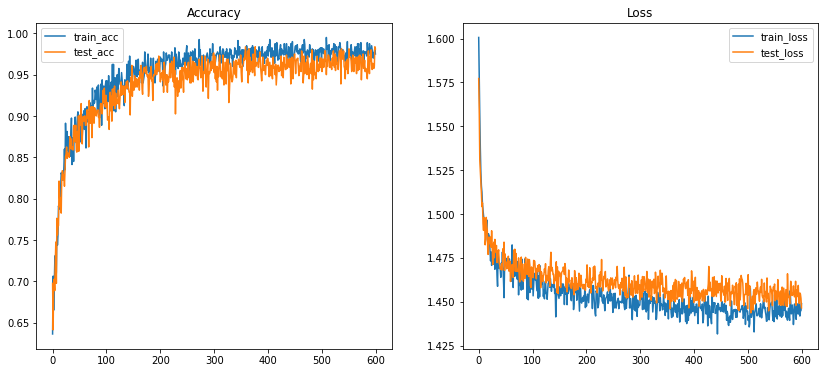

In [ ]:
# Training loop
with tqdm(zip(train_dataloader, val_dataloader), total=args.num_task_batch_train) as pbar:
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    for task_batch_idx, (train_batch, val_batch) in enumerate(pbar):
        if task_batch_idx >= args.num_task_batch_train:
            break

        train_accuracy, train_loss = train_matching(args, train_batch, model, criterion, optimizer)
        val_accuracy, val_loss = test_matching(args, val_batch, model, criterion, optimizer)

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        pbar.set_postfix(
            train_accuracy="{0:.4f}".format(train_accuracy),
            val_accuracy="{0:.4f}".format(val_accuracy),
            train_loss="{0:.4f}".format(train_loss),
            val_loss="{0:.4f}".format(val_loss),
        )

    # save model
    save_model(args, model, "matching_network.th")
    print_graph(train_accuracies, val_accuracies, train_losses, val_losses)

In [ ]:
# load model
load_model(args, model, "matching_network.th")

# Testing loop
with tqdm(test_dataloader, total=args.num_task_batch_test) as pbar:
    sum_test_accuracies = 0.0
    sum_test_losses = 0.0

    for task_batch_idx, test_batch in enumerate(pbar):
        if task_batch_idx >= args.num_task_batch_test:
            break

        test_accuracy, test_loss = test_matching(args, test_batch, model, criterion, optimizer)

        sum_test_accuracies += test_accuracy
        sum_test_losses += test_loss
        pbar.set_postfix(
            test_accuracy="{0:.4f}".format(sum_test_accuracies / (task_batch_idx + 1)),
            test_loss="{0:.4f}".format(sum_test_losses / (task_batch_idx + 1)),
        )

Load model


100%|██████████| 200/200 [02:22<00:00,  1.41it/s, test_accuracy=0.9586, test_loss=1.4558]
